In [1]:
# imports needed for the implementation
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.cm import get_cmap
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
!pip install tqdm
import tqdm as tqdm
import time
import numpy as np
from torch.utils.data import random_split
!pip install torchsummary
from torchsummary import summary
import statistics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# get initial train data without any alterations
train_data = datasets.FashionMNIST('data', train=True, download=True,
                                   transform=transforms.Compose([
                                      transforms.ToTensor(), 
                                   ]))
# load train data
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, num_workers= 1)

# get mean and standard deviation so it can be used for the normalization
n_samples_seen = 0.
mean = 0
std = 0
for train_batch, train_target in train_loader:
    batch_size = train_batch.shape[0]
    train_batch = train_batch.view(batch_size, -1)
    this_mean = torch.mean(train_batch, dim=1)
    this_std = torch.sqrt(
        torch.mean((train_batch - this_mean[:, None]) ** 2, dim=1))
    mean += torch.sum(this_mean, dim=0)
    std += torch.sum(this_std, dim=0)
    n_samples_seen += batch_size

mean /= n_samples_seen
std /= n_samples_seen

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# get train and test data but now with normalization, rotation and horizontal flip
train_data = datasets.FashionMNIST('data', train=True, download=False,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Resize((32,32)),
                                       transforms.RandomRotation(45),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.Normalize(mean=mean.view(1),
                                                            std=std.view(1))]))

test_data = datasets.FashionMNIST('data', train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((32,32)),
                                      transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=mean.view(1),
                                                           std=std.view(1))]))

# prepare train data and validation data
val_size = 10000
train_size = len(train_data) - val_size
# get a random validation set
train_set, val_set = random_split(train_data, [train_size, val_size])

# create train, validation and test loader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [4]:
class NET(nn.Module):
  def __init__(self):
    super(NET, self).__init__()
    
    # method that creates convolution layers
    def conv_block(in_channels, out_channels, pool=False):
      layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                nn.BatchNorm2d(out_channels), 
                nn.ReLU()]
      if pool: layers.append(nn.MaxPool2d(2))
      return nn.Sequential(*layers)

    self.conv1 = conv_block(1, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.classifier = nn.Sequential(
        nn.MaxPool2d(4), 
        nn.Flatten(), 
        nn.Dropout(0.2),
        nn.Linear(512, 10))
        
  # forward pass method
  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.classifier(out)
    return out

In [5]:
# load the device being used
device = "cuda" if torch.cuda.is_available() else "cpu"
# initiate the model with the specific device
model = NET().to(device)
# get params of the model
params = model.parameters()
# initiate optimiser with learning rate
optimiser = torch.optim.Adam(params, lr = 0.0001)
# initiate loss function
loss_function = nn.CrossEntropyLoss()
# show a summary of the CNN with the parameters of the FashionMNIST
summary(model, input_size=(1, 32, 32))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       640
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-4                       73,856
|    └─BatchNorm2d: 2-5                  256
|    └─ReLU: 2-6                         --
|    └─MaxPool2d: 2-7                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-8                       295,168
|    └─BatchNorm2d: 2-9                  512
|    └─ReLU: 2-10                        --
|    └─MaxPool2d: 2-11                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-12                      1,180,160
|    └─BatchNorm2d: 2-13                 1,024
|    └─ReLU: 2-14                        --
|    └─MaxPool2d: 2-15                   --
├─Sequential: 1-5                        --
|    └─MaxPool2d: 2-16                   --
|   

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       640
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-4                       73,856
|    └─BatchNorm2d: 2-5                  256
|    └─ReLU: 2-6                         --
|    └─MaxPool2d: 2-7                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-8                       295,168
|    └─BatchNorm2d: 2-9                  512
|    └─ReLU: 2-10                        --
|    └─MaxPool2d: 2-11                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-12                      1,180,160
|    └─BatchNorm2d: 2-13                 1,024
|    └─ReLU: 2-14                        --
|    └─MaxPool2d: 2-15                   --
├─Sequential: 1-5                        --
|    └─MaxPool2d: 2-16                   --
|   

In [6]:
# initialize arrays for ploting
plot_losses = []
plot_times = []
plot_accuracy_validation = []
epochs = 50
def train():
  # enter train mode
  model.train()
  # for each epoch run the training 
  for epoch in tqdm.tqdm(range(epochs)):
    # get the current time so we can calculate how long each epoch takes
    start_time = time.time()
    # initialize losses array
    losses = []
    # for each batch, images and labels get the parameters and train the model
    for batch_idx, (img, label) in enumerate(train_loader):
      # load image and label into the chosen device
      img = img.to(device)
      label = label.to(device)
      # set gradiants to zero before starting backpropagation
      optimiser.zero_grad()
      # get the result from the model
      outputs = model(img)
      # get the loss between the prediction and the output of the model
      loss = loss_function(outputs, label)
      # go back and update weights and biases
      loss.backward()
      optimiser.step()
      # append the loss to the list
      losses.append(loss.item())
    # upadate the lists with all the data to plot
    plot_losses.append(torch.tensor(losses).mean())
    end_time = time.time() - start_time 
    plot_times.append(end_time)
    print(f'\nEpoch {epoch + 1}, train loss: {torch.tensor(losses).mean():.2f}')

    with torch.no_grad():
        correct = 0
        samples = 0
        accuracy = 0
        for batch_idx, (img,label) in enumerate(val_loader):
            img = img.to(device)
            label = label.to(device)
            scores = model(img)
            _, predictions = scores.max(1)
            correct += (predictions == label).sum()
            samples += predictions.size(0)
            accuracy = float(correct) / float(samples) * 100
    plot_accuracy_validation.append(accuracy)        
    print(f"\nEpoch {epoch + 1} ] Accuracy : {accuracy:.2f}%")


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1, train loss: 0.74


  2%|▏         | 1/50 [01:08<56:06, 68.71s/it]


Epoch 1 ] Accuracy : 79.10%

Epoch 2, train loss: 0.51


  4%|▍         | 2/50 [02:08<50:43, 63.42s/it]


Epoch 2 ] Accuracy : 81.80%

Epoch 3, train loss: 0.45


  6%|▌         | 3/50 [03:07<48:08, 61.46s/it]


Epoch 3 ] Accuracy : 83.23%

Epoch 4, train loss: 0.42


  8%|▊         | 4/50 [04:06<46:21, 60.47s/it]


Epoch 4 ] Accuracy : 84.52%

Epoch 5, train loss: 0.39


 10%|█         | 5/50 [05:05<44:51, 59.81s/it]


Epoch 5 ] Accuracy : 84.95%

Epoch 6, train loss: 0.37


 12%|█▏        | 6/50 [06:04<43:42, 59.60s/it]


Epoch 6 ] Accuracy : 86.51%

Epoch 7, train loss: 0.36


 14%|█▍        | 7/50 [07:04<42:47, 59.70s/it]


Epoch 7 ] Accuracy : 86.11%

Epoch 8, train loss: 0.34


 16%|█▌        | 8/50 [08:02<41:21, 59.08s/it]


Epoch 8 ] Accuracy : 86.90%

Epoch 9, train loss: 0.33


 18%|█▊        | 9/50 [09:00<40:09, 58.78s/it]


Epoch 9 ] Accuracy : 86.86%

Epoch 10, train loss: 0.33


 20%|██        | 10/50 [09:57<38:55, 58.39s/it]


Epoch 10 ] Accuracy : 86.96%

Epoch 11, train loss: 0.32


 22%|██▏       | 11/50 [10:55<37:48, 58.18s/it]


Epoch 11 ] Accuracy : 88.19%

Epoch 12, train loss: 0.31


 24%|██▍       | 12/50 [11:52<36:36, 57.79s/it]


Epoch 12 ] Accuracy : 87.59%

Epoch 13, train loss: 0.30


 26%|██▌       | 13/50 [12:49<35:35, 57.71s/it]


Epoch 13 ] Accuracy : 87.51%

Epoch 14, train loss: 0.30


 28%|██▊       | 14/50 [13:47<34:35, 57.66s/it]


Epoch 14 ] Accuracy : 88.04%

Epoch 15, train loss: 0.29


 30%|███       | 15/50 [14:45<33:38, 57.68s/it]


Epoch 15 ] Accuracy : 88.51%

Epoch 16, train loss: 0.28


 32%|███▏      | 16/50 [15:41<32:33, 57.46s/it]


Epoch 16 ] Accuracy : 88.76%

Epoch 17, train loss: 0.28


 34%|███▍      | 17/50 [16:38<31:30, 57.29s/it]


Epoch 17 ] Accuracy : 88.17%

Epoch 18, train loss: 0.28


 36%|███▌      | 18/50 [17:36<30:33, 57.30s/it]


Epoch 18 ] Accuracy : 88.98%

Epoch 19, train loss: 0.27


 38%|███▊      | 19/50 [18:33<29:38, 57.38s/it]


Epoch 19 ] Accuracy : 89.08%

Epoch 20, train loss: 0.27


 40%|████      | 20/50 [19:30<28:36, 57.22s/it]


Epoch 20 ] Accuracy : 88.92%

Epoch 21, train loss: 0.26


 42%|████▏     | 21/50 [20:27<27:36, 57.12s/it]


Epoch 21 ] Accuracy : 89.78%

Epoch 22, train loss: 0.26


 44%|████▍     | 22/50 [21:25<26:44, 57.30s/it]


Epoch 22 ] Accuracy : 89.97%

Epoch 23, train loss: 0.26


 46%|████▌     | 23/50 [22:21<25:42, 57.13s/it]


Epoch 23 ] Accuracy : 89.82%

Epoch 24, train loss: 0.25


 48%|████▊     | 24/50 [23:19<24:49, 57.29s/it]


Epoch 24 ] Accuracy : 89.60%

Epoch 25, train loss: 0.25


 50%|█████     | 25/50 [24:17<23:57, 57.49s/it]


Epoch 25 ] Accuracy : 89.72%

Epoch 26, train loss: 0.25


 52%|█████▏    | 26/50 [25:15<23:02, 57.61s/it]


Epoch 26 ] Accuracy : 89.91%

Epoch 27, train loss: 0.25


 54%|█████▍    | 27/50 [26:12<21:57, 57.29s/it]


Epoch 27 ] Accuracy : 90.39%

Epoch 28, train loss: 0.25


 56%|█████▌    | 28/50 [27:09<21:03, 57.44s/it]


Epoch 28 ] Accuracy : 89.91%

Epoch 29, train loss: 0.24


 58%|█████▊    | 29/50 [28:07<20:06, 57.44s/it]


Epoch 29 ] Accuracy : 89.89%

Epoch 30, train loss: 0.24


 60%|██████    | 30/50 [29:04<19:10, 57.52s/it]


Epoch 30 ] Accuracy : 89.29%

Epoch 31, train loss: 0.23


 62%|██████▏   | 31/50 [30:01<18:08, 57.31s/it]


Epoch 31 ] Accuracy : 89.70%

Epoch 32, train loss: 0.23


 64%|██████▍   | 32/50 [30:58<17:09, 57.18s/it]


Epoch 32 ] Accuracy : 89.80%

Epoch 33, train loss: 0.23


 66%|██████▌   | 33/50 [31:55<16:12, 57.23s/it]


Epoch 33 ] Accuracy : 89.74%

Epoch 34, train loss: 0.23


 68%|██████▊   | 34/50 [32:53<15:18, 57.41s/it]


Epoch 34 ] Accuracy : 90.24%

Epoch 35, train loss: 0.22


 70%|███████   | 35/50 [33:50<14:18, 57.21s/it]


Epoch 35 ] Accuracy : 90.39%

Epoch 36, train loss: 0.22


 72%|███████▏  | 36/50 [34:47<13:18, 57.05s/it]


Epoch 36 ] Accuracy : 90.55%

Epoch 37, train loss: 0.22


 74%|███████▍  | 37/50 [35:44<12:22, 57.12s/it]


Epoch 37 ] Accuracy : 90.42%

Epoch 38, train loss: 0.22


 76%|███████▌  | 38/50 [36:41<11:24, 57.07s/it]


Epoch 38 ] Accuracy : 90.55%

Epoch 39, train loss: 0.22


 78%|███████▊  | 39/50 [37:38<10:26, 56.91s/it]


Epoch 39 ] Accuracy : 91.12%

Epoch 40, train loss: 0.22


 80%|████████  | 40/50 [38:34<09:28, 56.89s/it]


Epoch 40 ] Accuracy : 90.05%

Epoch 41, train loss: 0.22


 82%|████████▏ | 41/50 [39:32<08:34, 57.16s/it]


Epoch 41 ] Accuracy : 91.07%

Epoch 42, train loss: 0.21


 84%|████████▍ | 42/50 [40:29<07:35, 56.96s/it]


Epoch 42 ] Accuracy : 90.36%

Epoch 43, train loss: 0.21


 86%|████████▌ | 43/50 [41:25<06:37, 56.83s/it]


Epoch 43 ] Accuracy : 91.01%

Epoch 44, train loss: 0.21


 88%|████████▊ | 44/50 [42:22<05:40, 56.79s/it]


Epoch 44 ] Accuracy : 90.87%

Epoch 45, train loss: 0.21


 90%|█████████ | 45/50 [43:20<04:46, 57.29s/it]


Epoch 45 ] Accuracy : 90.46%

Epoch 46, train loss: 0.21


 92%|█████████▏| 46/50 [44:17<03:48, 57.23s/it]


Epoch 46 ] Accuracy : 90.39%

Epoch 47, train loss: 0.21


 94%|█████████▍| 47/50 [45:14<02:50, 56.99s/it]


Epoch 47 ] Accuracy : 90.32%

Epoch 48, train loss: 0.20


 96%|█████████▌| 48/50 [46:10<01:53, 56.76s/it]


Epoch 48 ] Accuracy : 90.57%

Epoch 49, train loss: 0.20


 98%|█████████▊| 49/50 [47:08<00:57, 57.09s/it]


Epoch 49 ] Accuracy : 91.28%

Epoch 50, train loss: 0.20


100%|██████████| 50/50 [48:05<00:00, 57.70s/it]


Epoch 50 ] Accuracy : 91.25%
[79.10000000000001, 81.8, 83.23, 84.52, 84.95, 86.50999999999999, 86.11, 86.9, 86.86, 86.96000000000001, 88.19, 87.59, 87.51, 88.03999999999999, 88.51, 88.75999999999999, 88.17, 88.98, 89.08, 88.92, 89.78, 89.97, 89.82, 89.60000000000001, 89.72, 89.91, 90.39, 89.91, 89.89, 89.29, 89.7, 89.8, 89.74, 90.24, 90.39, 90.55, 90.42, 90.55, 91.12, 90.05, 91.07, 90.36, 91.01, 90.86999999999999, 90.46, 90.39, 90.32, 90.57, 91.28, 91.25]


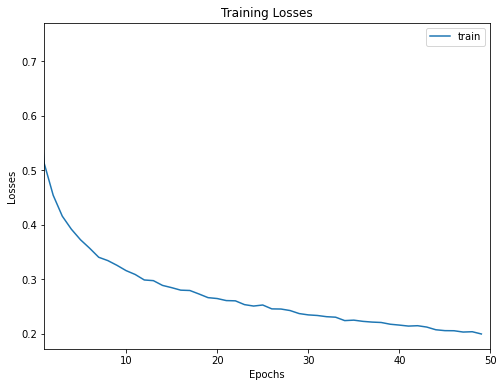

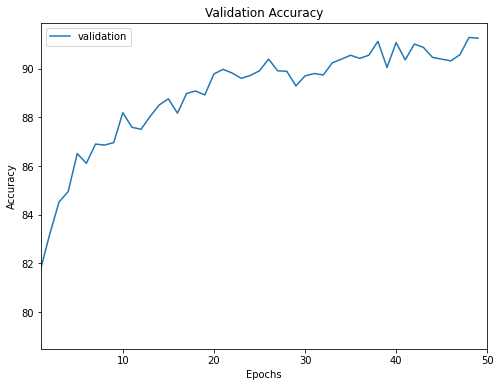

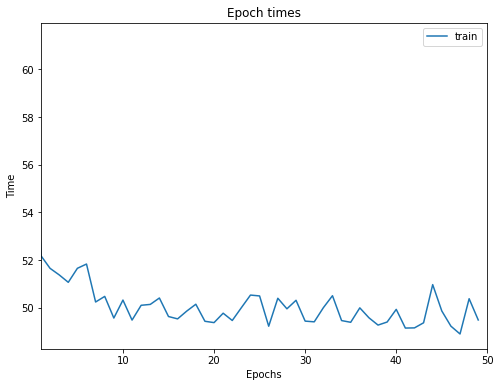

In [ ]:
#train the model
train()

# plot 
plt.figure(figsize=(8, 6))
plt.plot(plot_losses, label='train')
plt.legend()
plt.title("Training Losses")
plt.xlim([1, epochs])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(plot_accuracy_validation, label='validation')
plt.legend()
plt.title("Validation Accuracy")
plt.xlim([1, epochs])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(plot_times, label='train')
plt.legend()
plt.title("Epoch times")
plt.xlim([1, epochs])
plt.xlabel("Epochs")
plt.ylabel("Time")
plt.show()

In [ ]:
# save the model
torch.save(model.state_dict(), "./assignment2.pt")
# load the model created 
model.load_state_dict(torch.load("./assignment2.pt"))
model.to(device)

NET(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReL

In [ ]:
# method for testing the trained model
def test():
  # put model in evaluation mode
  model.eval()
  # initialize variables
  correct = 0
  samples = 0
  # go over the test data
  for batch_idx, (img,label) in tqdm.tqdm(enumerate(test_loader)):
      img = img.to(device)
      label = label.to(device)
      scores = model(img)
      # get prediction
      _, predictions = scores.max(1)
      # if prediction is correct increment
      correct += (predictions == label).sum()
      samples += predictions.size(0)
  # return accuracy
  return(float(correct) / float(samples) * 100)

313it [00:06, 46.64it/s]



 Test 1 -> Accuracy 91.84%


313it [00:06, 47.77it/s]



 Test 2 -> Accuracy 91.89%


313it [00:06, 48.04it/s]



 Test 3 -> Accuracy 91.95%


313it [00:06, 47.14it/s]



 Test 4 -> Accuracy 91.89%


313it [00:06, 46.86it/s]



 Test 5 -> Accuracy 91.85%


313it [00:06, 46.98it/s]



 Test 6 -> Accuracy 91.98%


313it [00:06, 46.51it/s]



 Test 7 -> Accuracy 91.87%


313it [00:06, 47.62it/s]



 Test 8 -> Accuracy 91.68%


313it [00:06, 47.72it/s]



 Test 9 -> Accuracy 91.59%


313it [00:06, 47.33it/s]



 Test 10 -> Accuracy 91.85%

Mean accuracy -> 91.84




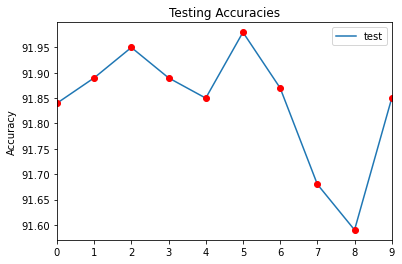

In [ ]:
# list of accuracies to keep track and show in a plot
accuracies = []
# repeat testing 10 times
for i in range(0,10):
  # get accuracy from the test 
  acc = test()
  # add it to the list
  accuracies.append(acc)
  # print accuracy
  print(f"\n Test {i + 1} -> Accuracy {acc:.2f}%")


# Show the average of the accuracies
print(f"\nMean accuracy -> {round(statistics.mean(accuracies), 2)}")
# give space between printed accuracy and plot
print("\n")
# create a plot with the accuracies from the testing
plt.figure()
plt.plot(accuracies, label='test')
plt.plot(accuracies, 'ro')
plt.legend()
plt.title("Testing Accuracies")
plt.xlim([0, 9])
plt.ylabel("Accuracy")
plt.show()